In [58]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df['priceL'] = np.log(df['price'])
df
#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

,date,price,wallets,address,mined,priceL
0,2010-09-25,0.1,2,656.0,4109450.00,-2.302585
1,2010-09-26,0.1,2,444.0,4110750.00,-2.302585
2,2010-09-27,0.1,2,1070.0,4132150.00,-2.302585
3,2010-09-28,0.1,2,1503.0,4133200.00,-2.302585
4,2010-09-29,0.1,2,1049.0,4148050.00,-2.302585
...,...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25,9.860716
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75,9.862916
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00,9.881814
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25,9.869491


In [59]:
df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

m = Prophet()
m.fit(df_train)

n_years =1
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:24 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4746,2023-10-21,11.194030,9.614784,12.512273
4747,2023-10-22,11.201162,9.632063,12.621148
4748,2023-10-23,11.210814,9.614953,12.676281
4749,2023-10-24,11.221879,9.598538,12.661453
4750,2023-10-25,11.235788,9.546945,12.629138


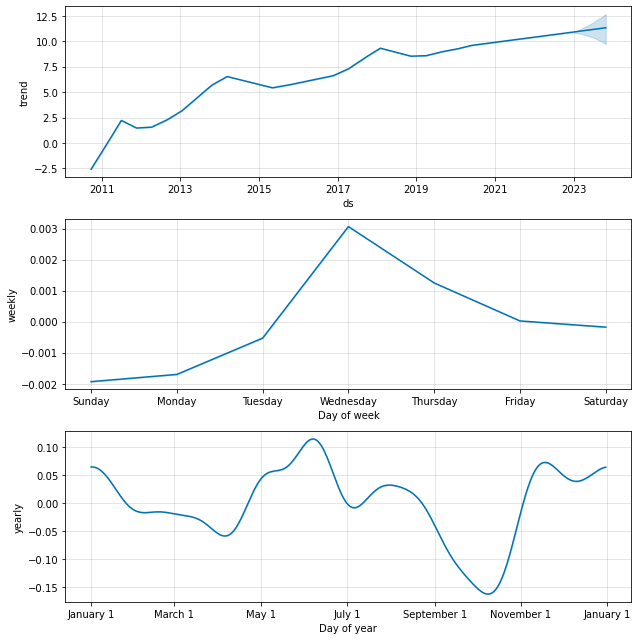

In [61]:
fig2 = m.plot_components(forecast)

In [62]:
df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing
22:19:30 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing


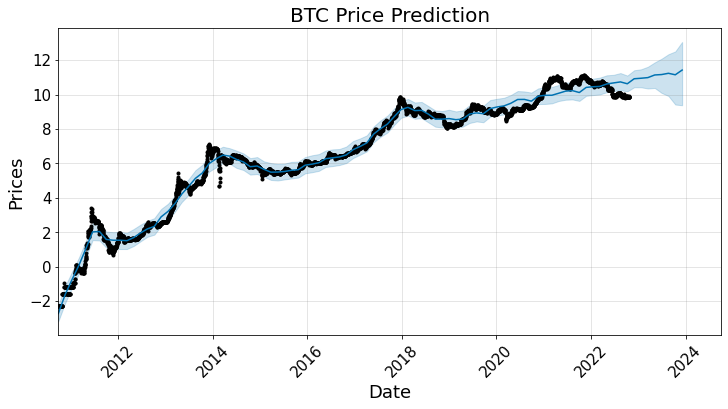

<Figure size 432x288 with 0 Axes>

In [63]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2023-12-06", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-10-01'])) 
plt.show();
plt.savefig("../static/logprices.png")

In [65]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_train.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [66]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(r2_score(metric_df.y, metric_df.yhat))
print(mean_squared_error(metric_df.y, metric_df.yhat))
print(mean_absolute_error(metric_df.y, metric_df.yhat))

0.9866223684767609
0.13905698624678187
0.280933703757847


In [67]:
np.exp(metric_df['y'])


0           0.1
1           0.1
2           0.1
3           0.1
4           0.1
         ...   
4381    19162.6
4382    19204.8
4383    19571.2
4384    19331.5
4385    20073.1
Name: y, Length: 4386, dtype: float64

In [69]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df['date'], y=df['price'], legendrank=4))
fig.add_trace(go.Scatter(name="Middle Bound Prediction", x=prediction['ds'], y=np.exp(prediction['yhat']), legendrank=2))
# fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=np.exp(prediction['yhat_lower']), legendrank=1))
# fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_yaxes(type="log")
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prices and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Prices")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=40)
fig.update_layout(
    margin=dict(l=5, r=120, t=70, b=50),
)


fig.layout.template = 'plotly_dark'
fig.write_html('../static/logprices.html')
fig.show()